In [ ]:
#To upload the file from desktop
from google.colab import files
uploaded = files.upload()

Saving co2_mm_mlo.csv to co2_mm_mlo.csv


#Classical RNN model

   year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0  1958      3     1958.2027   315.71          314.44     -1 -9.99 -0.99
1  1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2  1958      5     1958.3699   317.51          314.69     -1 -9.99 -0.99
3  1958      6     1958.4548   317.27          315.15     -1 -9.99 -0.99
4  1958      7     1958.5370   315.87          315.20     -1 -9.99 -0.99
Epoch 1/50


<ipython-input-22-8f07b91fc77e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_relevant['average'] = data_relevant['average'].replace(-9.99, None).ffill()
<ipython-input-22-8f07b91fc77e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_relevant['average_scaled'] = scaler.fit_transform(data_relevant[['average']])


20/20 [==============================] - 1s 18ms/step - loss: 0.2396 - val_loss: 0.0469
Epoch 2/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0044
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/50
20/20 [==============================] - 0s 8ms/step - loss: 7.8689e-04 - val_loss: 6.0320e-04
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 4.7861e-04 - val_loss: 4.3571e-04
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 4.3654e-04 - val_loss: 4.1632e-04
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 3.8152e-04 - val_loss: 4.1047e-04
Epoch 8/50
20/20 [==============================] - 0s 6ms/step - loss: 3.6669e-04 - val_loss: 3.3054e-04
Epoch 9/50
20/20 [==============================] - 0s 6ms/step - loss: 2.8716e-04 - val_loss: 2.8337e-04
Epoch 10/50
20/20 [==============================] - 0s 6ms/step - loss: 2.8137e

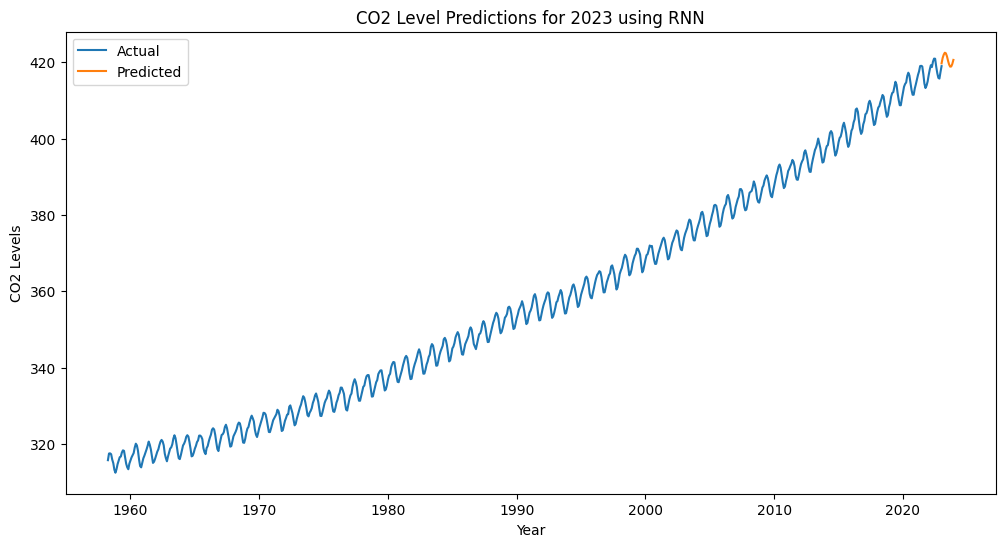

Predicted CO2 levels for 2023 using RNN: [419.72726 421.13867 422.00363 422.5143  422.37225 421.58987 420.4214
 419.42413 418.86282 418.90897 419.56836 420.62943]
1/1 [==============================] - 0s 21ms/step
Predicted CO2 levels for 2023: [419.72726 421.13867 422.00363 422.5143  422.37225 421.58987 420.4214
 419.42413 418.86282 418.90897 419.56836 420.62943]


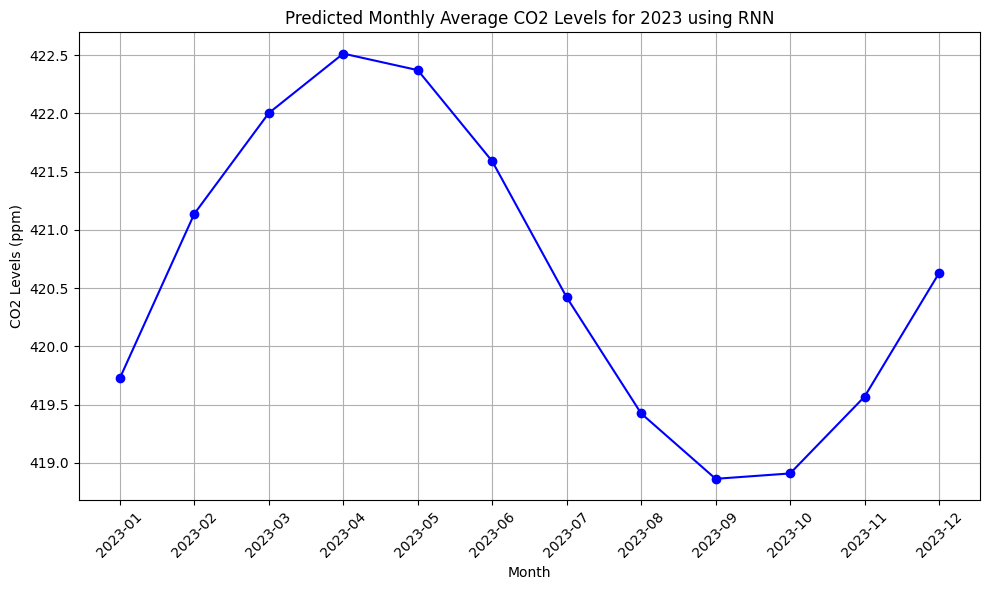

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt

# Upload and read the data
data = pd.read_csv('co2_mm_mlo.csv')
print(data.head())

# Extract relevant columns and handle missing values
data_relevant = data[['year', 'month', 'average']]
data_relevant['average'] = data_relevant['average'].replace(-9.99, None).ffill()

# Normalize the data
scaler = MinMaxScaler()
data_relevant['average_scaled'] = scaler.fit_transform(data_relevant[['average']])

# Create sequences for RNN
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 12
X, y = create_sequences(data_relevant['average_scaled'].values, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the RNN model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions for the next 12 months
last_sequence = data_relevant['average_scaled'].values[-sequence_length:]
input_sequence = last_sequence.reshape((1, sequence_length, 1))

predictions = []
for _ in range(12):
    next_value = model.predict(input_sequence)[0][0]
    predictions.append(next_value)
    input_sequence = np.append(input_sequence[:, 1:, :], [[[next_value]]], axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(data_relevant['year'] + data_relevant['month']/12, data_relevant['average'], label='Actual')
plt.plot(np.arange(2023, 2024, 1/12), predictions, label='Predicted')
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.title('CO2 Level Predictions for 2023 using RNN')
plt.legend()
plt.show()

print('Predicted CO2 levels for 2023 using RNN:', predictions.flatten())

# Create input sequence from the last 12 months in the training data
last_sequence = data_relevant['average_scaled'].values[-sequence_length:]
input_sequence = last_sequence.reshape((1, sequence_length, 1))

# Predict the next 12 months
classical_predictions = []
for _ in range(12):
    next_value = model.predict(input_sequence)[0][0]
    classical_predictions.append(next_value)
    input_sequence = np.append(input_sequence[:, 1:, :], [[[next_value]]], axis=1)

# Convert predictions back to original scale
classical_predictions = scaler.inverse_transform(np.array(classical_predictions).reshape(-1, 1))

# Print predictions
print('Predicted CO2 levels for 2023:', classical_predictions.flatten())

# Import necessary library for plotting
import matplotlib.pyplot as plt

# Create a list of months for 2023
months = [f'2023-{i:02d}' for i in range(1, 13)]

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(months, classical_predictions, marker='o', linestyle='-', color='b')
plt.title('Predicted Monthly Average CO2 Levels for 2023 using RNN')
plt.xlabel('Month')
plt.ylabel('CO2 Levels (ppm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Introducing Quantum Layers - Quantum RNN model

   year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0  1958      3     1958.2027   315.71          314.44     -1 -9.99 -0.99
1  1958      4     1958.2877   317.45          315.16     -1 -9.99 -0.99
2  1958      5     1958.3699   317.51          314.69     -1 -9.99 -0.99
3  1958      6     1958.4548   317.27          315.15     -1 -9.99 -0.99
4  1958      7     1958.5370   315.87          315.20     -1 -9.99 -0.99


<ipython-input-25-2066f7098e98>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_relevant['average'] = data_relevant['average'].replace(-9.99, None).ffill()
<ipython-input-25-2066f7098e98>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_relevant['average_scaled'] = scaler.fit_transform(data_relevant[['average']])


Epoch [10/3000], Loss: 0.4959, Val Loss: 0.4916
Epoch [20/3000], Loss: 0.3271, Val Loss: 0.3231
Epoch [30/3000], Loss: 0.2847, Val Loss: 0.2890
Epoch [40/3000], Loss: 0.2443, Val Loss: 0.2499
Epoch [50/3000], Loss: 0.2168, Val Loss: 0.2223
Epoch [60/3000], Loss: 0.1926, Val Loss: 0.1981
Epoch [70/3000], Loss: 0.1714, Val Loss: 0.1769
Epoch [80/3000], Loss: 0.1527, Val Loss: 0.1582
Epoch [90/3000], Loss: 0.1366, Val Loss: 0.1420
Epoch [100/3000], Loss: 0.1229, Val Loss: 0.1283
Epoch [110/3000], Loss: 0.1116, Val Loss: 0.1170
Epoch [120/3000], Loss: 0.1024, Val Loss: 0.1077
Epoch [130/3000], Loss: 0.0951, Val Loss: 0.1004
Epoch [140/3000], Loss: 0.0894, Val Loss: 0.0946
Epoch [150/3000], Loss: 0.0849, Val Loss: 0.0901
Epoch [160/3000], Loss: 0.0813, Val Loss: 0.0863
Epoch [170/3000], Loss: 0.0778, Val Loss: 0.0825
Epoch [180/3000], Loss: 0.0731, Val Loss: 0.0774
Epoch [190/3000], Loss: 0.0649, Val Loss: 0.0680
Epoch [200/3000], Loss: 0.0484, Val Loss: 0.0498
Epoch [210/3000], Loss: 0.041

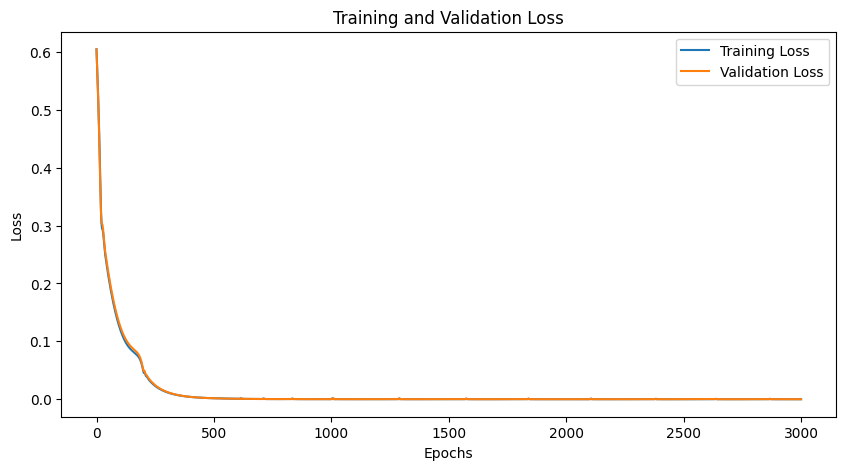

Test Loss: 0.0001
Predicted CO2 levels for 2023: [418.30055325 419.01276718 419.52201457 419.90475887 419.93028982
 419.6120005  418.96790362 418.43344878 418.16518615 418.24740798
 418.55179956 418.75263098]


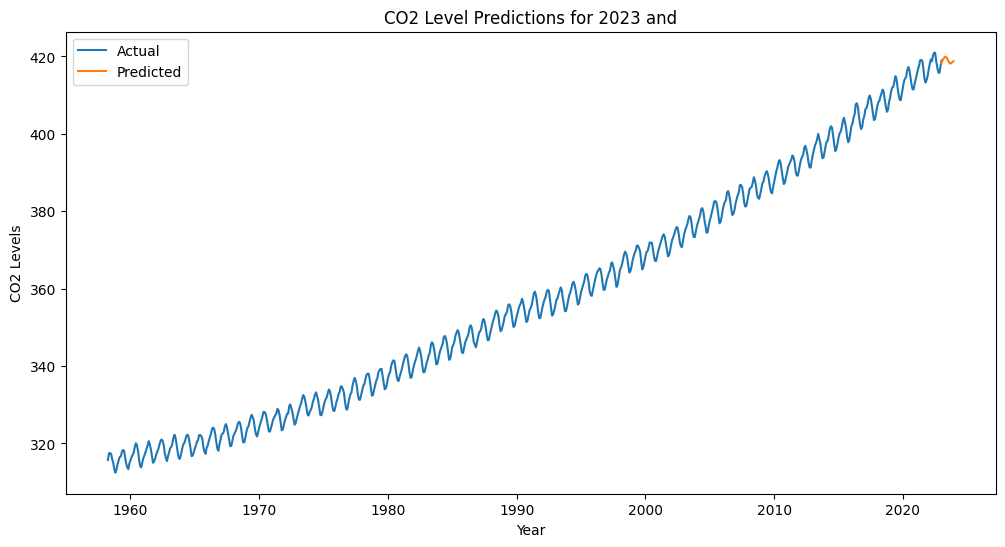

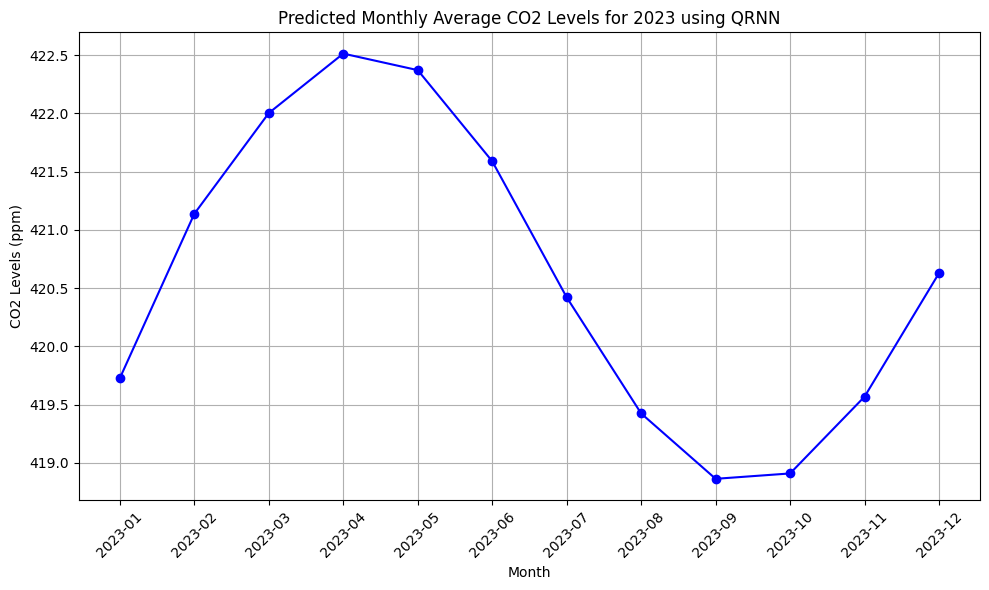

In [ ]:
!pip install pennylane

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv('co2_mm_mlo.csv')
print(data.head())

# Extract relevant columns and handle missing values
data_relevant = data[['year', 'month', 'average']]
data_relevant['average'] = data_relevant['average'].replace(-9.99, None).ffill()

# Normalize the data
scaler = MinMaxScaler()
data_relevant['average_scaled'] = scaler.fit_transform(data_relevant[['average']])

# Create sequences for RNN
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 12
X, y = create_sequences(data_relevant['average_scaled'].values, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Define the quantum circuit and device
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (3, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="backprop")

class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

class HybridRNN(nn.Module):
    def __init__(self, sequence_length, input_dim, hidden_dim, output_dim):
        super(HybridRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_qubits)
        self.quantum = QuantumLayer()
        self.fc2 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :])
        out = self.quantum(out)
        out = self.fc2(out)
        return out

# Hyperparameters
sequence_length = 12
input_dim = 1
hidden_dim = 50
output_dim = 1

# Initialize model, loss function, and optimizer
model = HybridRNN(sequence_length, input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Train the model
epochs = 3000
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output, y_test)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    test_loss = criterion(model(X_test), y_test)
print(f'Test Loss: {test_loss.item():.4f}')

# Make predictions for 2023
model.eval()
last_sequence = torch.tensor(data_relevant['average_scaled'].values[-sequence_length:], dtype=torch.float32).view(1, -1, 1).to(device)
predictions = []

for _ in range(12):
    with torch.no_grad():
        next_value = model(last_sequence).item()
    predictions.append(next_value)
    last_sequence = torch.cat((last_sequence[:, 1:, :], torch.tensor(next_value).view(1, 1, 1).to(device)), dim=1)

# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print('Predicted CO2 levels for 2023:', predictions.flatten())

# Plot actual vs predicted CO2 levels
plt.figure(figsize=(12, 6))
plt.plot(data_relevant['year'] + data_relevant['month']/12, data_relevant['average'], label='Actual')
plt.plot(np.arange(2023, 2024, 1/12), predictions, label='Predicted')
plt.xlabel('Year')
plt.ylabel('CO2 Levels')
plt.title('CO2 Level Predictions for 2023 and')
plt.legend()
plt.show()

# Create a list of months for 2023
months = [f'2023-{i:02d}' for i in range(1, 13)]

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(months, classical_predictions, marker='o', linestyle='-', color='b')
plt.title('Predicted Monthly Average CO2 Levels for 2023 using QRNN')
plt.xlabel('Month')
plt.ylabel('CO2 Levels (ppm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

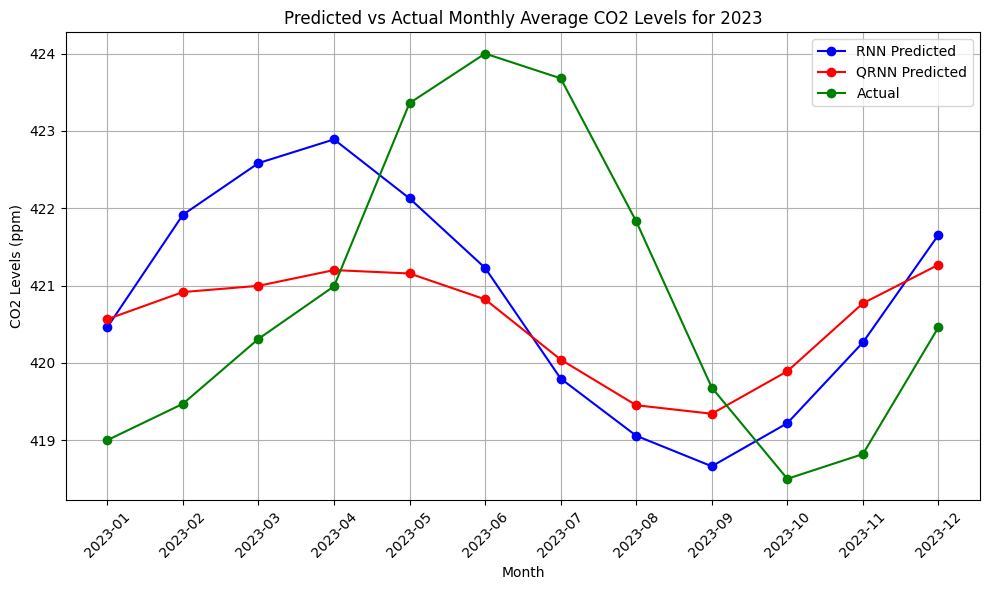

Predicted CO2 levels for 2023 using RNN: [420.4603  421.91522 422.5834  422.8902  422.12662 421.22775 419.79663
 419.0571  418.6623  419.21948 420.26392 421.6545 ]
Predicted CO2 levels for 2023 using QRNN: [420.56514095 420.91562541 420.99628148 421.19962329 421.15596316
 420.82121394 420.04212523 419.45179474 419.34160921 419.89111346
 420.77048848 421.26864615]
Actual CO2 levels for 2023: [419.   419.47 420.31 420.99 423.36 424.   423.68 421.83 419.68 418.5
 418.82 420.46]


In [ ]:
# RNN predictions have already been generated and are in classical_predictions
# QRNN predictions have already been generated and are in predictions

# Actual CO2 levels for 2023
actual_values = np.array([419.00, 419.47, 420.31, 420.99, 423.36, 424.00, 423.68, 421.83, 419.68, 418.50, 418.82, 420.46])

# Create a list of months for 2023
months = [f'2023-{i:02d}' for i in range(1, 13)]

# Convert predictions and actual values to pandas DataFrames
classical_predictions_df = pd.DataFrame(classical_predictions, columns=['classical_predictions'])
qrnn_predictions_df = pd.DataFrame(predictions, columns=['qrnn_predictions'])
actual_values_df = pd.DataFrame(actual_values, columns=['actual_values'])

# Combine predictions and actual values into a single DataFrame
combined_predictions_df = pd.DataFrame(months, columns=['month'])
combined_predictions_df['classical_predictions'] = classical_predictions_df
combined_predictions_df['qrnn_predictions'] = qrnn_predictions_df
combined_predictions_df['actual_values'] = actual_values_df

# Plot the predictions and actual values for each month
plt.figure(figsize=(10, 6))
plt.plot(months, combined_predictions_df['classical_predictions'], marker='o', linestyle='-', color='b', label='RNN Predicted')
plt.plot(months, combined_predictions_df['qrnn_predictions'], marker='o', linestyle='-', color='r', label='QRNN Predicted')
plt.plot(months, combined_predictions_df['actual_values'], marker='o', linestyle='-', color='g', label='Actual')
plt.title('Predicted vs Actual Monthly Average CO2 Levels for 2023')
plt.xlabel('Month')
plt.ylabel('CO2 Levels (ppm)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print predictions
print('Predicted CO2 levels for 2023 using RNN:', classical_predictions.flatten())
print('Predicted CO2 levels for 2023 using QRNN:', qrnn_predictions.flatten())
print('Actual CO2 levels for 2023:', actual_values)


Predicted CO2 levels for 2023-2024: [418.30055325 419.01276718 419.52201457 419.90475887 419.93028982
 419.6120005  418.96790362 418.43344878 418.16518615 418.24740798
 418.55179956 418.75263098 418.86832902 419.17613681 419.39631377
 419.50503707 419.48549741 419.36347163 419.18708419 419.03756054
 418.95181899 418.93722248 418.96886119 419.02115241]


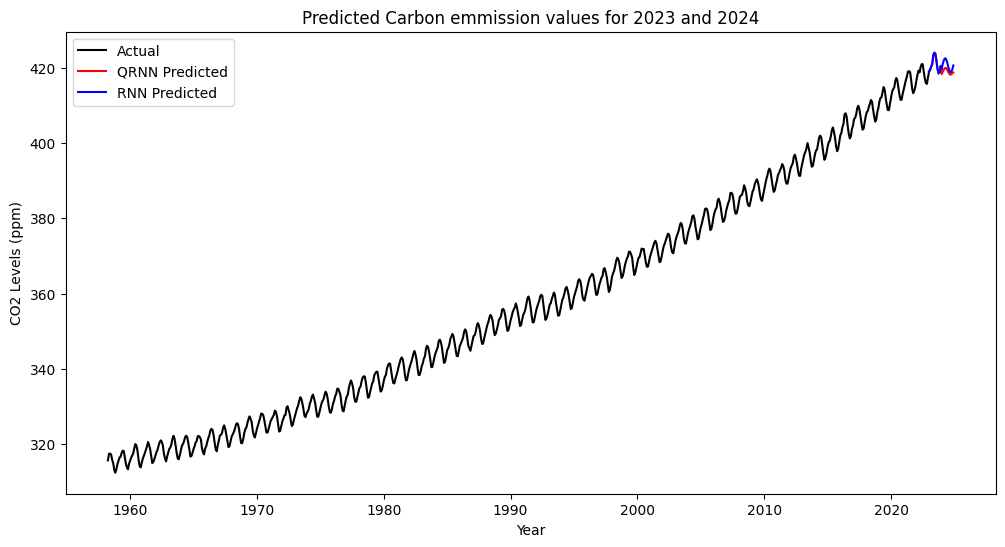

In [ ]:
# Make predictions for 2023 and 2024
model.eval()
last_sequence = torch.tensor(data_relevant['average_scaled'].values[-sequence_length:], dtype=torch.float32).view(1, -1, 1).to(device)
predictions_qrnn = []

for _ in range(24):
    with torch.no_grad():
        next_value = model(last_sequence).item()
    predictions_qrnn.append(next_value)
    last_sequence = torch.cat((last_sequence[:, 1:, :], torch.tensor(next_value).view(1, 1, 1).to(device)), dim=1)

# Convert predictions back to original scale
predictions_qrnn = scaler.inverse_transform(np.array(predictions_qrnn).reshape(-1, 1))
print('Predicted CO2 levels for 2023-2024:', predictions_qrnn.flatten())

# Actual CO2 levels for 2023
actual_values_2023 = np.array([419.00, 419.47, 420.31, 420.99, 423.36, 424.00, 423.68, 421.83, 419.68, 418.50, 418.82, 420.46])

# Create a list of months for 2023 and 2024
months = [f'2023-{i:02d}' for i in range(1, 13)] + [f'2024-{i:02d}' for i in range(1, 13)]

# Plot actual vs predicted CO2 levels
plt.figure(figsize=(12, 6))
plt.plot(data_relevant['year'] + data_relevant['month'] / 12, data_relevant['average'], label='Actual', color='black')
plt.plot(np.arange(2023, 2025, 1 / 12)[:24], np.append(actual_values_2023, predictions_qrnn.flatten()[:12]), label='QRNN Predicted', color='red')
plt.plot(np.arange(2023, 2025, 1 / 12)[:24], np.append(actual_values_2023, classical_predictions.flatten()[:12]), label='RNN Predicted', color='blue')
plt.xlabel('Year')
plt.ylabel('CO2 Levels (ppm)')
plt.title('Predicted Carbon emmission values for 2023 and 2024')
plt.legend()
plt.show()
